# Sprint 10 - Proyecto: Cómo contar una historia utilizando datos

-   [Introducción](#introducción)
-   [Cargar Datos](#cargar-datos)
-   [Análisis de Datos](#análisis-de-datos)
    -   [Gráfico de Pastel](#gráfico-de-pastel)
    -   [Proporcion de los establecimientos que pertenecen a una cadena](#proporcion-de-los-establecimientos-que-pertenecen-a-una-cadena)
    -   [Histogramas para análisis](#histogramas-para-análisis)
-   [Conclusiones](#coclusiones)

## Introducción

<b> Descripción del proyecto </b>

Has decidido abrir un pequeño café atendido por robots en Los Ángeles. El proyecto es prometedor pero caro, así que tú y tus compañeros decidís intentar atraer inversionistas. Están interesados en las condiciones actuales del mercado, ¿serás capaz de mantener tu éxito cuando el bombo de los camareros robot desaparezca?

Eres un gurú del análisis así que te han pedido que prepares un estudio de mercado. Tienes datos procedentes de fuentes abiertas sobre restaurantes en LA.

<b> Instrucciones para completar el proyecto </b>

1. Descarga los datos y prepáralos para el análisis

    -   Descarga los datos de los restaurantes en LA. Asegúrate de que el tipo de datos para cada columna es correcto y que no hay valores ausentes o duplicados. Procésalos si es necesario.
    -   Ruta de archivo: /datasets/rest_data_us_upd.csv. Descargar dataset

2. Análisis de datos

    -   Investiga las proporciones de los distintos tipos de establecimientos. Traza un gráfico.
    -   Investiga las proporciones de los establecimientos que pertenecen a una cadena y de los que no. Traza un gráfico.
    -   ¿Qué tipo de establecimiento es habitualmente una cadena?
    -   ¿Qué caracteriza a las cadenas: muchos establecimientos con un pequeño número de asientos o unos pocos establecimientos con un montón de asientos?
    -   Determina el promedio de número de asientos para cada tipo de restaurante. De promedio, ¿qué tipo de restaurante tiene el mayor número de asientos? Traza gráficos.
    -   Coloca los datos de los nombres de las calles de la columna address en una columna separada.
    -   Traza un gráfico de las diez mejores calles por número de restaurantes.
    -   a el número de calles que solo tienen un restaurante.
    -   Para las calles con muchos restaurantes, analiza la distribución del número de asientos. ¿Qué tendencias puedes ver?
    -   Llega a una conclusión y aporta recomendaciones sobre el tipo de restaurante y el número de asientos. Comenta la posibilidad de desarrollar una cadena.

3. Preparar una presentación

    -   Prepara una presentación de tu investigación para compartir con el grupo de inversionistas. Puedes utilizar cualquier herramienta para crearla pero debes convertir tu presentación a formato PDF para la evaluación. Incluye un enlace a la presentación en una celda markdown en el siguiente formato:
    -   Presentation: "enlace al almacenamiento en la nube"
    -   Sigue las directrices de formato del capítulo "Preparar presentaciones".
    -   Formato: Completa el ejercicio en un Jupyter notebook. Inserta el código en las celdas code y las explicaciones de texto en las celdas markdown. Aplica formato y encabezados.

Descripción de datos

Tabla rest_data:

-   object_name — nombre del establecimiento
-   chain — establecimiento que pertenece a una cadena (TRUE/FALSE)
-   object_type — tipo de establecimiento
-   address — dirección
-   number — número de asientos

## Cargar datos

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import math as mt
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import os
from plotly import graph_objects as go
from fuzzywuzzy import process

In [2]:
def data_load():	
    ruta_archivo = os.path.join('datasets', 'rest_data_us_upd.csv')
    data = pd.read_csv(
	    ruta_archivo,
	    dtype={'chain': 'category'}#, 'Source Id': 'int'}, 
	    # parse_dates = ['End Ts', 'Start Ts'],
	    # nrows = 500
	)
    # visits_dl.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
    return data

In [3]:
data = data_load()

In [4]:
data.info( memory_usage= True )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9651 non-null   int64   
 1   object_name  9651 non-null   object  
 2   address      9651 non-null   object  
 3   chain        9648 non-null   category
 4   object_type  9651 non-null   object  
 5   number       9651 non-null   int64   
dtypes: category(1), int64(2), object(3)
memory usage: 386.6+ KB


## Análisis de Datos

In [5]:
for column in data.columns:
    data = data.dropna(subset=[column])

data['chain'] = data['chain'].map({'True': True, 'False': False})
# data['chain'] = data['chain'].astype(bool)

In [6]:
data.head(5)

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [7]:
def extraer_direccion(direccion):
    # Expresión regular para capturar direcciones cardinales seguidas de un número y el nombre de la calle
    match = re.search(r'\b([NSEW])\b\s([\dA-Za-z\s]+)', direccion)
    if match:
        # Devolver dirección cardinal y nombre de la calle
        return f"{match.group(1)} {match.group(2).strip()}"
    else:
        # Manejar direcciones sin dirección cardinal pero con nombre de calle
        match_sin_cardinal = re.search(r'([A-Za-z\s]+)', direccion)
        if match_sin_cardinal:
            return match_sin_cardinal.group(1).strip()
    return None

# Aplicar la función a la columna 'direccion'
data['calle'] = data['address'].apply(extraer_direccion)

In [8]:
data['calle'] = data['calle'].str.replace(r'\s+\d+$', '', regex=True)

Función para normalizar los nombres de los negocios, se revisó su funcionamiento para una muestra de 500 filas, pero es muy pesado aplicarlo en el dataset completo, por eso se dejó comentada, sin embargo, con tiempo suficiente y un buen ordenador se puede aplicar.

In [9]:
# # Definir una función para encontrar el nombre más cercano
# def get_closest_match(name, choices):
#     match, score = process.extractOne(name, choices)
#     return match

# # Crear una lista única de nombres de negocios
# unique_names = data['object_name'].unique()

# # Crear un diccionario para mapear nombres similares a un nombre estándar
# name_mapping = {name: get_closest_match(name, unique_names) for name in unique_names}

# # Mapear los nombres en el DataFrame
# data['normalized_negocio'] = data['object_name'].map(name_mapping)

# # Mostrar el DataFrame con nombres normalizados
# print(data[['object_name', 'normalized_negocio']])

In [10]:
# # Guardar el dataframe resultante, para verificar el resultado de las direcciones nuevas
# data.to_csv('direccion.csv', index= False, sep=',')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9648 entries, 0 to 9650
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           9648 non-null   int64   
 1   object_name  9648 non-null   object  
 2   address      9648 non-null   object  
 3   chain        9648 non-null   category
 4   object_type  9648 non-null   object  
 5   number       9648 non-null   int64   
 6   calle        9648 non-null   object  
dtypes: category(1), int64(2), object(4)
memory usage: 537.1+ KB


### Gráfico de Pastel

In [12]:
data_type = data.groupby(by= 'object_type', as_index= False).agg({'id' : 'count'})
print(data_type)

fig = go.Figure(data=[go.Pie(labels= data_type['object_type'], values=data_type['id'])])
fig.show()

  object_type    id
0      Bakery   283
1         Bar   292
2        Cafe   435
3   Fast Food  1066
4       Pizza   319
5  Restaurant  7253


### Proporcion de los establecimientos que pertenecen a una cadena

In [13]:
data_type = data.groupby(by= ['object_type', 'chain'],  observed=False).agg({'id' : 'count'})
print(data_type)

                     id
object_type chain      
Bakery      False     0
            True    283
Bar         False   215
            True     77
Cafe        False   169
            True    266
Fast Food   False   461
            True    605
Pizza       False   166
            True    153
Restaurant  False  4961
            True   2292


In [30]:
fig = px.histogram(data, x='object_type', color= 'chain',  title='Proporcion de los establecimientos que pertenecen a una cadena', color_discrete_sequence=['green', 'orange'])
fig.update_layout(
    legend_title_text='Es cadena?', 
    xaxis_title='Tipo de Establecimiento',  # Etiqueta del eje X
    yaxis_title='Número de Establecimientos'  # Etiqueta del eje Y
    )
fig.show()

<b>Establecimientos No Cadena vs. Cadena </b>

1. **Panadería**:
   - **Cuentas No Cadena**: 0
   - **Cuentas de Cadena**: 283
   - **Análisis**: Todas las panaderías son cadenas, lo que sugiere que este tipo de establecimiento ha encontrado un modelo de negocio efectivo que funciona en formato de cadena. La falta de panaderías no cadena puede indicar una alta concentración en el mercado de cadenas o la dificultad para competir en este segmento.

2. **Bar**:
   - **Cuentas No Cadena**: 215
   - **Cuentas de Cadena**: 77
   - **Análisis**: Los bares no cadena superan en número a los de cadena, lo que podría indicar una preferencia de los consumidores por las experiencias únicas y personalizadas que suelen ofrecer los bares independientes. Esto puede representar una oportunidad para las cadenas de diferenciarse al ofrecer experiencias exclusivas o innovadoras.

3. **Café**:
   - **Cuentas No Cadena**: 169
   - **Cuentas de Cadena**: 266
   - **Análisis**: Aunque los cafés de cadena tienen más cuentas que los no cadena, la diferencia no es tan pronunciada. Esto sugiere que, aunque las cadenas son populares, hay un mercado considerable para los cafés independientes, posiblemente debido a la búsqueda de productos artesanales y ambientes únicos.

4. **Comida Rápida**:
   - **Cuentas No Cadena**: 461
   - **Cuentas de Cadena**: 605
   - **Análisis**: La comida rápida tiene una presencia fuerte tanto en cadenas como en no cadenas, pero las cadenas tienen una ligera ventaja. Esto puede reflejar la conveniencia y la velocidad del servicio que los consumidores buscan en este tipo de establecimiento, aunque hay un mercado considerable para opciones no cadena.

5. **Pizza**:
   - **Cuentas No Cadena**: 166
   - **Cuentas de Cadena**: 153
   - **Análisis**: La cercanía en números entre cadenas y no cadenas sugiere que los consumidores están igualmente interesados en ambas opciones. Esto puede indicar un equilibrio en la preferencia, donde algunos consumidores prefieren la variedad y el sabor local de las pizzerías no cadena, mientras que otros eligen la consistencia de las cadenas.

6. **Restaurante**:
   - **Cuentas No Cadena**: 4961
   - **Cuentas de Cadena**: 2292
   - **Análisis**: Los restaurantes no cadena dominan claramente en este segmento, lo que indica que los consumidores valoran las experiencias culinarias únicas y personalizadas que ofrecen los restaurantes independientes. Esto representa una oportunidad significativa para las cadenas de restaurantes que buscan aumentar su cuota de mercado, quizás mediante la innovación en el menú o la mejora del servicio.

<b> Conclusión General </b>
- En la mayoría de los casos, los establecimientos de cadena parecen atraer a más clientes, pero hay excepciones notables como las panaderías y los bares, donde las no cadenas son más populares. Esto sugiere que las preferencias de los consumidores varían según el tipo de establecimiento, y las cadenas deben considerar estrategias específicas para atraer a diferentes segmentos de clientes.
- La presencia significativa de establecimientos no cadena en los restaurantes y bares indica un mercado potencial donde las cadenas podrían mejorar su presencia mediante la creación de experiencias más únicas y personalizadas, adaptándose a las preferencias locales.

### Histogramas para análisis

Percentiles los asientos de establecimientos que son cadena:
 [90 95 99] % 
 [107.   140.   206.25] $


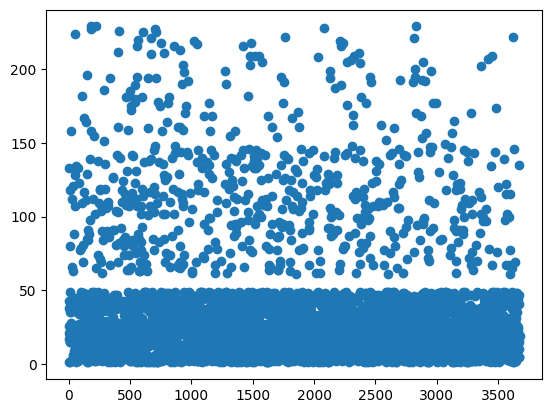

In [15]:
chain = data[data['chain'] == True]

x_values = pd.Series(range(0,len(chain)))

plt.scatter(x_values, chain['number'])

percentiles = np.percentile(chain['number'], [90, 95, 99])

print(f'Percentiles los asientos de establecimientos que son cadena:\n', '[90 95 99] % \n', percentiles, '$')

32.63625965112954


C:\Users\ulise\AppData\Local\Temp\ipykernel_18884\1780552779.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='number', ylabel='Density'>

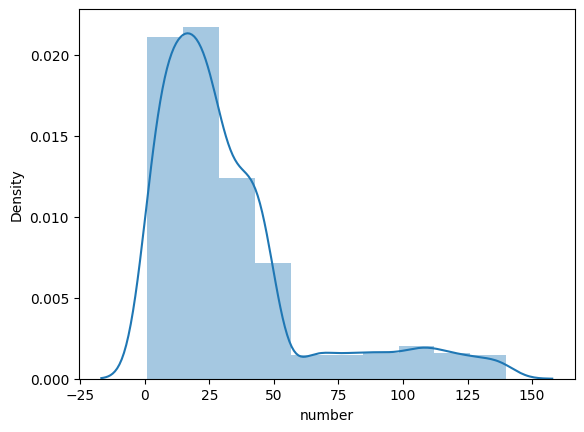

In [16]:
chain = data[(data['chain'] == True) & (data['number'] <= 140)]
print(chain['number'].mean())

sns.distplot(chain['number'], bins=10)

El histograma que proporcionas muestra la distribución de un conjunto de datos que parecen representar el número de asientos en distintos restaurantes. A continuación, algunos puntos clave del análisis:

1. **Distribución Sesgada a la Derecha**: 
   La mayoría de los restaurantes parecen tener menos de 50 asientos, ya que la densidad es mayor entre 0 y 50. Sin embargo, hay un grupo reducido de restaurantes con más asientos, ya que se observan valores hasta alrededor de 150, aunque la frecuencia es mucho menor.

2. **Moda**: 
   El pico más alto está alrededor de los 20-30 asientos. Esto indica que la mayoría de los restaurantes en el conjunto de datos tienden a tener este número de asientos.

3. **Cola Larga**: 
   Se observa una cola en la parte derecha del histograma, lo que sugiere que aunque hay pocos restaurantes con un número de asientos más alto (por encima de 75), algunos alcanzan hasta aproximadamente 150 asientos.

4. **Posible Presencia de Outliers**: 
   En la zona de asientos superiores a 100, puede haber algunos valores atípicos o restaurantes mucho más grandes, pero la frecuencia es muy baja.

5. **Rango de Datos**:
   Los datos parecen estar distribuidos entre aproximadamente 0 y 150 asientos, pero con una gran concentración de restaurantes en los primeros 50 asientos.

Este gráfico muestra una distribución típica en sectores como la restauración, donde muchos restaurantes tienden a ser pequeños o medianos, con unos pocos establecimientos mucho más grandes que cuentan con más asientos.

In [40]:
fig = px.histogram(chain, x='number',  title='Histograma del número de asientos de establecimientos que son cadenas', color_discrete_sequence=['orange'], nbins= 20)
fig.update_layout(
    legend_title_text='Es cadena?', 
    yaxis_title='Frecuencia',  # Etiqueta del eje X
    xaxis_title='Número de asientos'  # Etiqueta del eje Y
    )
fig.show()

Percentiles los asientos de establecimientos que no son cadena:
 [90 95 99] % 
 [128. 160. 218.] $


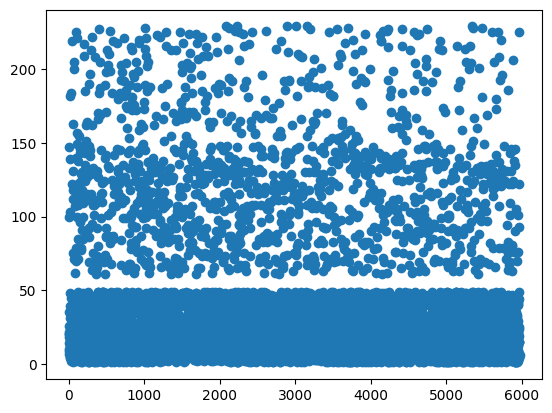

In [17]:
chainNo = data[data['chain'] == False]

x_values = pd.Series(range(0,len(chainNo)))

plt.scatter(x_values, chainNo['number'])

percentiles = np.percentile(chainNo['number'], [90, 95, 99])

print(f'Percentiles los asientos de establecimientos que no son cadena:\n', '[90 95 99] % \n', percentiles, '$')

38.37533039647577


C:\Users\ulise\AppData\Local\Temp\ipykernel_18884\2763552393.py:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='number', ylabel='Density'>

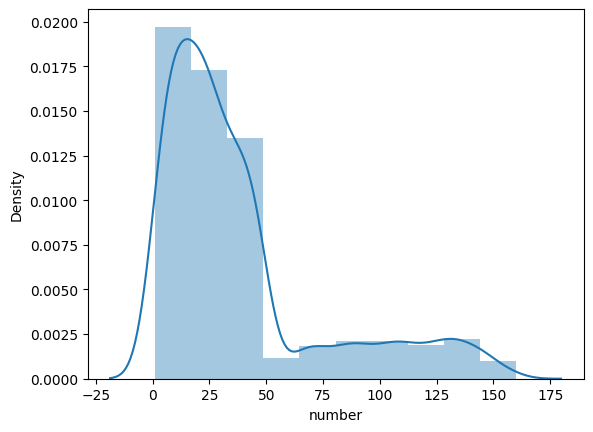

In [18]:
chainNo = data[(data['chain'] == False) & (data['number'] <= 160)]
print(chainNo['number'].mean())

sns.distplot(chainNo['number'], bins=10)

El histograma que proporcionas muestra la distribución de un conjunto de datos que parecen representar el número de asientos en distintos establecimientos. A continuación, algunos puntos clave del análisis:

1. **Distribución Sesgada a la Derecha**: 
   La mayoría de los establecimientos parecen tener menos de 50 asientos, ya que la densidad es mayor entre 0 y 50. Sin embargo, hay un grupo reducido de establecimientos con más asientos, ya que se observan valores hasta alrededor de 150, aunque la frecuencia es mucho menor, aunque mayor que en los establecimientos tipo cadena.

2. **Moda**: 
   El pico más alto está alrededor de los 0-10 asientos. Esto indica que la mayoría de los establecimientos en el conjunto de datos tienden a tener este número de asientos.

3. **Cola Larga**: 
   Se observa una cola en la parte derecha del histograma, lo que sugiere que aunque hay pocos establecimientos con un número de asientos más alto (por encima de 75), algunos alcanzan hasta aproximadamente 150 asientos.

4. **Posible Presencia de Outliers**: 
   En la zona de asientos superiores a 100, puede haber algunos valores atípicos o establecimientos mucho más grandes, pero la frecuencia es muy baja.

5. **Rango de Datos**:
   Los datos parecen estar distribuidos entre aproximadamente 0 y 150 asientos, pero con una gran concentración de establecimientos en los primeros 50 asientos.

Este gráfico muestra una distribución típica en sectores como la restauración, donde muchos establecimientos tienden a ser pequeños o medianos, con unos pocos establecimientos mucho más grandes que cuentan con más asientos.

In [39]:
fig = px.histogram(chainNo, x='number',  title='Histograma del número de asientos de establecimientos que no son cadenas', color_discrete_sequence=['green'], nbins= 20)
fig.update_layout(
    legend_title_text='Es cadena?', 
    yaxis_title='Frecuencia',  # Etiqueta del eje X
    xaxis_title='Número de asientos'  # Etiqueta del eje Y
    )
fig.show()

In [19]:
data_95 = pd.concat([chain, chainNo], axis=0)

In [33]:
fig = px.histogram(data_95, x='number', color= 'chain',  title='Histograma del número de asientos de establecimientos', color_discrete_sequence=['green', 'orange'])
fig.update_layout(
    legend_title_text='Es cadena?', 
    yaxis_title='Frecuencia',  # Etiqueta del eje X
    xaxis_title='Número de asientos'  # Etiqueta del eje Y
    )
fig.show()

In [34]:
data_95 = data_95[data_95['number'] <= 50]
fig = px.histogram(data_95, x='number', color= 'chain',  title='Histograma del número de asientos de establecimientos [0 - 50]', color_discrete_sequence=['green', 'orange'])
fig.update_layout(
    legend_title_text='Es cadena?', 
    yaxis_title='Frecuencia',  # Etiqueta del eje X
    xaxis_title='Número de asientos'  # Etiqueta del eje Y
    )
fig.show()

In [22]:
streets = data.groupby(by= 'calle', as_index = False).agg({'object_name' : 'count'})
streets = streets.sort_values(by = 'object_name', ascending= False)
print(streets.head(10))

                  calle  object_name
1356      W SUNSET BLVD          317
1328        W PICO BLVD          309
1432      WILSHIRE BLVD          229
310      HOLLYWOOD BLVD          199
987       S WESTERN AVE          199
1023  SANTA MONICA BLVD          198
1140           W 3RD ST          184
753       S FIGUEROA ST          177
968       S VERMONT AVE          175
1307     W OLYMPIC BLVD          160


In [23]:
fig = px.bar(streets.head(10), x='calle', y= 'object_name',  title='Número de establecimientos por calle')
fig.update_layout(
    xaxis_title='Calle',  # Etiqueta del eje X
    yaxis_title= 'Cantidad de  establecimientos'  # Etiqueta del eje Y
    )
fig.show()

In [24]:
streets = streets.sort_values(by = 'object_name')
print(streets[streets['object_name'] == 1])

                     calle  object_name
1169         W 6TH ST 110B            1
314     HOLLYWOOD BLVD FLR            1
313      HOLLYWOOD BLVD FL            1
311       HOLLYWOOD BLVD B            1
307           HILHURST AVE            1
...                    ...          ...
944     S SEPULVEDA BLVD B            1
943   S SEPULVEDA BLVD 1FL            1
1351   W SLAUSON AVE STE A            1
1352  W SLAUSON AVE STE A2            1
1324  W OLYMPIC BLVD STE C            1

[908 rows x 2 columns]


In [25]:
streets = streets.sort_values(by = 'object_name', ascending= False)
# data_street = data[data['calle']]
street_names = streets['calle'].head(10).tolist()
print(street_names)

['W SUNSET BLVD', 'W PICO BLVD', 'WILSHIRE BLVD', 'HOLLYWOOD BLVD', 'S WESTERN AVE', 'SANTA MONICA BLVD', 'W 3RD ST', 'S FIGUEROA ST', 'S VERMONT AVE', 'W OLYMPIC BLVD']


In [26]:
data_filtro_streets = data[data['calle'].isin(street_names)]
data_filtro_streets = data_filtro_streets[data_filtro_streets['number'] <= 50]

In [27]:
fig = px.histogram(data_filtro_streets, x='number', color= 'calle',  title='Distribución del número de asientos', nbins=25)
fig.update_layout(
    legend_title_text='Calle', 
    xaxis_title='Cantidad de asientos',  # Etiqueta del eje X
    yaxis_title= 'Frecuencia'  # Etiqueta del eje Y
    )
fig.show()

In [41]:
fig = px.histogram(data_filtro_streets, x='number',  title='Distribución del número de asientos', nbins=25)
fig.update_layout(
    legend_title_text='Calle', 
    xaxis_title='Cantidad de asientos',  # Etiqueta del eje X
    yaxis_title= 'Frecuencia'  # Etiqueta del eje Y
    )
fig.show()

La gráfica que compartes es un histograma apilado que representa la distribución del número de asientos en negocios relacionados con la comida, distribuidos en diferentes calles. A continuación, un análisis detallado:

<b> 1. **Distribución General**: </b>
   - El gráfico muestra la cantidad de asientos en el eje X, con valores que parecen estar en el rango de 0 a 50.
   - En el eje Y se muestra la **frecuencia** (número de negocios), que alcanza hasta aproximadamente 80.
   - Cada barra representa un rango de asientos y está segmentada por color, donde cada color representa una calle diferente. Esto permite ver no solo cuántos negocios hay en cada rango de asientos, sino también cómo se distribuyen esos negocios entre las diferentes calles.

<b> 2. **Calles Más Representadas**: </b>
   - Las calles con mayor representación en términos de número de negocios parecen ser **HOLLYWOOD BLVD**, **SANTA MONICA BLVD**, **W PICO BLVD** y **W OLYMPIC BLVD**, dado que estas ocupan las mayores porciones de las barras en varios rangos de asientos.
   - Las calles menos representadas son **S VERMONT AVE**, **S WESTERN AVE**, y **S FIGUEROA ST**, ya que aparecen con menos frecuencia en las barras y ocupan menos espacio.

<b> 3. **Distribución por Número de Asientos**: </b>
   - El rango de asientos parece estar bastante disperso entre 0 y 50, pero no se observa un patrón claro donde una cantidad específica de asientos sea dominante.
   - La distribución es bastante uniforme, lo que significa que no hay un pico claro de negocios con un número específico de asientos, sino que hay una representación variada en casi todos los rangos de asientos.

<b> 4. **Tendencias por Calle**: </b>
   - **HOLLYWOOD BLVD** tiene una presencia constante en casi todos los rangos de asientos, especialmente en aquellos con entre 0 y 40 asientos. Esto sugiere que en esta calle hay una diversidad considerable en cuanto al tamaño de los negocios.
   - **SANTA MONICA BLVD** también parece tener una presencia significativa en casi todos los rangos de asientos, lo que indica que esta calle tiene negocios de diferentes tamaños.
   - Otras calles como **W SUNSET BLVD** y **WILSHIRE BLVD** tienen representación, pero no tan consistente como las dos anteriores, lo que podría sugerir que hay una menor concentración de negocios o que estos tienen una capacidad más específica.

<b> 5. **Patrones Generales**: </b>
   - El gráfico no muestra una gran concentración en ningún rango específico de asientos; más bien, la distribución es más dispersa y las calles tienen una mezcla de tamaños de negocios.
   - Es interesante notar cómo algunas calles tienen una mayor proporción en ciertos rangos de asientos, lo que podría indicar que las políticas urbanas o el tipo de clientes en esas calles influyen en el tamaño de los negocios.

<b> 6. **Posibles Insights**: </b>
   - Si el objetivo es identificar las calles con mayor diversidad en cuanto a la capacidad de asientos, **HOLLYWOOD BLVD** y **SANTA MONICA BLVD** son las más relevantes, ya que tienen representación en casi todos los rangos de asientos.
   - Si te interesa localizar calles con negocios más pequeños (menos de 10 asientos), podrías enfocarte en calles como **S VERMONT AVE** y **S WESTERN AVE**, que tienen menor representación en los rangos superiores.
   - Para áreas con negocios más grandes, algunas calles como **WILSHIRE BLVD** parecen tener una mayor presencia en los rangos superiores de 40-50 asientos.

<b> Conclusión: </b>
Este gráfico permite ver de manera efectiva cómo están distribuidos los tamaños de los negocios en distintas calles. Puedes observar patrones interesantes en cuanto a la diversidad de tamaños de los establecimientos en diferentes calles, lo que puede ser útil para análisis de planificación urbana, marketing o estudios de mercado.

Si deseas hacer ajustes en la gráfica o comparar estas calles con otras variables, como el tipo de negocio o su rentabilidad, también es posible profundizar en el análisis.

### Coclusiones

Para maximizar las probabilidades de éxito de un café atendido por robots en Los Ángeles y atraer inversionistas, es importante considerar la información obtenida de las gráficas analizadas sobre la distribución de negocios relacionados con la comida en diversas calles de la ciudad.

<b> Recomendaciones sobre el tipo de establecimiento: </b>

<b> 1. **Innovación Tecnológica**: </b>
   Un café atendido por robots es una propuesta altamente innovadora, lo cual ya te da una ventaja competitiva. El enfoque debería ser en **cafeterías de experiencia** que se enfoquen no solo en la calidad del producto, sino en la atracción del cliente por la novedad del servicio robótico. Puedes ofrecer:
   - Demostraciones de los robots en acción, donde los clientes puedan interactuar de alguna manera con ellos.
   - Automatización completa desde la toma de órdenes hasta la entrega de productos.

<b> 2. **Ubicación**: </b>
   Con base en las gráficas que muestran la distribución de asientos por calle, algunas calles clave tienen una mayor diversidad de tamaño de negocios y tráfico:
   - **HOLLYWOOD BLVD** y **SANTA MONICA BLVD** son lugares muy concurridos con una amplia variedad de negocios de todos los tamaños, lo que sugiere una alta afluencia de clientes.
   - Estas calles atraen tanto a residentes como a turistas, por lo que podrías ubicar tu café en una de ellas para aprovechar el flujo constante de personas.
   
   Además, las calles como **WILSHIRE BLVD** o **W SUNSET BLVD** también podrían ser buenas opciones para un concepto innovador como el tuyo, aunque quizás más orientado hacia la clase media-alta o clientes más interesados en la tecnología.

<b> Recomendaciones sobre el tamaño del establecimiento: </b>

<b> 1. **Cantidad de Asientos**: </b>
   Basándonos en los histogramas, la mayoría de los negocios tienen entre 20 y 30 asientos, lo que sugiere que esta es la capacidad ideal para una pequeña cafetería en Los Ángeles. Esto parece estar relacionado con los espacios urbanos más compactos y la rentabilidad de los locales pequeños.
   
   **Propuesta de asientos**:
   - **20 a 30 asientos**: Es un rango adecuado para comenzar sin incurrir en altos costos de mantenimiento o renta. Además, este tamaño te permitirá una alta rotación de clientes sin comprometer la comodidad.
   - Puedes considerar algunos asientos al aire libre si las regulaciones locales lo permiten, lo que también atrae a personas que prefieren estar al aire libre, especialmente en una ciudad como Los Ángeles con buen clima.

<b> 2. **Flexibilidad**: </b>
   Dado que tu propuesta es innovadora, puedes adoptar un enfoque más flexible, tal vez con algunos asientos de "alta tecnología" (como estaciones de carga inalámbrica, interacción con los robots), lo cual podría atraer a clientes que buscan una experiencia única más que solo un lugar para sentarse.

<b> Factores adicionales a considerar para los inversionistas: </b>

1. **Mercado turístico**: Los Ángeles atrae millones de turistas cada año, y tu café atendido por robots puede convertirse en un atractivo turístico en sí mismo, sobre todo en áreas como Hollywood o Santa Monica.
   
2. **Enfoque en la eficiencia**: Los inversionistas estarán interesados en cómo la tecnología robótica puede mejorar la eficiencia y reducir los costos operativos, un punto clave que debes resaltar. Puedes destacar que:
   - El uso de robots minimiza errores en las órdenes.
   - Los costos laborales se reducen, permitiendo un margen más alto de rentabilidad a largo plazo.

3. **Estrategias de marketing**: El concepto de un café atendido por robots es atractivo para redes sociales y prensa, lo cual te da una oportunidad de aprovechar la promoción viral y generar publicidad orgánica. Considera incluir una estrategia de marketing sólida que resalte la innovación tecnológica y la experiencia única.

<b> Comentarios finales </b>

Para atraer inversionistas y mejorar las probabilidades de éxito en el mercado de Los Ángeles, te recomendaría:
- **Abrir un café con 20 a 30 asientos** para equilibrar el costo inicial con la demanda esperada.
- **Ubicar el café en zonas concurridas** como **HOLLYWOOD BLVD** o **SANTA MONICA BLVD** donde la afluencia de público y el interés por experiencias innovadoras es mayor.
- **Destacar la propuesta de valor tecnológica y la eficiencia** en términos de ahorro de costos operativos.